# Predict The Next Movie To Watch
Goal of this project:   
1. Preprocess the Movielens dataset from the perspective of session based recommendation was systematically carried out.
2. The RNN-based predictive model was normally configured and training proceeded stably.
3. Changed the session definition, model structure, hyperparameters, etc. and observed the changes in Recall and MRR.

# Dataset
Movielens 1M Dataset (https://grouplens.org/datasets/movielens/1m/)   
Stable benchmark dataset. 1 million ratings from 6000 users on 4000 movies. Released 2/2003.

Using this Movielens dataset, I will create a SBR system (Session based Recommendation system)

# Table of Contents
1. Load the Data
2. Data Preprocessing
3. Train / Valid / Test Data Split
4. Data Pipeline
5. Model Configuration
6. Model Train
7. Model Test and check Recall and MRR

In [5]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [6]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

In [7]:
data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # sort by id and timestamp
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [9]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

## Session Length
- Session_length means the number of data rows that share the same SessionId. 
- SessionId is a user identifier that is always included when connecting to the web server from the browser. Even if we don't know who this user is because we're not logged in, we can at least classify the behavior of a specific user by SessionId. 
- Session_length here means how many actions the user of the session took during the session (how many product information was clicked).

1. UserID should act as SessionID.

2. Rating information is included. Ny using this rating information, whether or not you liked the last movie you saw may have something to do with choosing more similar movies. You also need to think about how to handle low-rated data.

3. The Time item includes UTC time, and the time in seconds that has elapsed since January 1, 1970 is listed.

In [10]:
user_length = data.groupby('UserId').size()
user_length.min(), user_length.max()

(20, 2314)

In [11]:
user_length.quantile(0.99)

906.659999999998

Let's check users with length of 400

In [12]:
long_user = user_length[user_length==400].index[0]
data[data['UserId']==long_user]

,UserId,ItemId,Rating,Time
3421,26,593,3,978130429
3581,26,2915,4,978130465
3603,26,511,5,978130485
3717,26,480,4,978130485
3673,26,3249,3,978130684
...,...,...,...,...
3469,26,185,3,978276085
3670,26,3247,2,978276085
3566,26,2262,5,978384764
3451,26,1784,5,978384872


In [13]:
length_count = user_length.groupby(user_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_99 = length_percent_cumsum[length_percent_cumsum < 0.99]

length_percent_cumsum_99

20     0.014238
21     0.029305
22     0.042053
23     0.055464
24     0.068874
         ...   
888    0.989073
893    0.989404
894    0.989570
900    0.989735
903    0.989901
Length: 684, dtype: float64

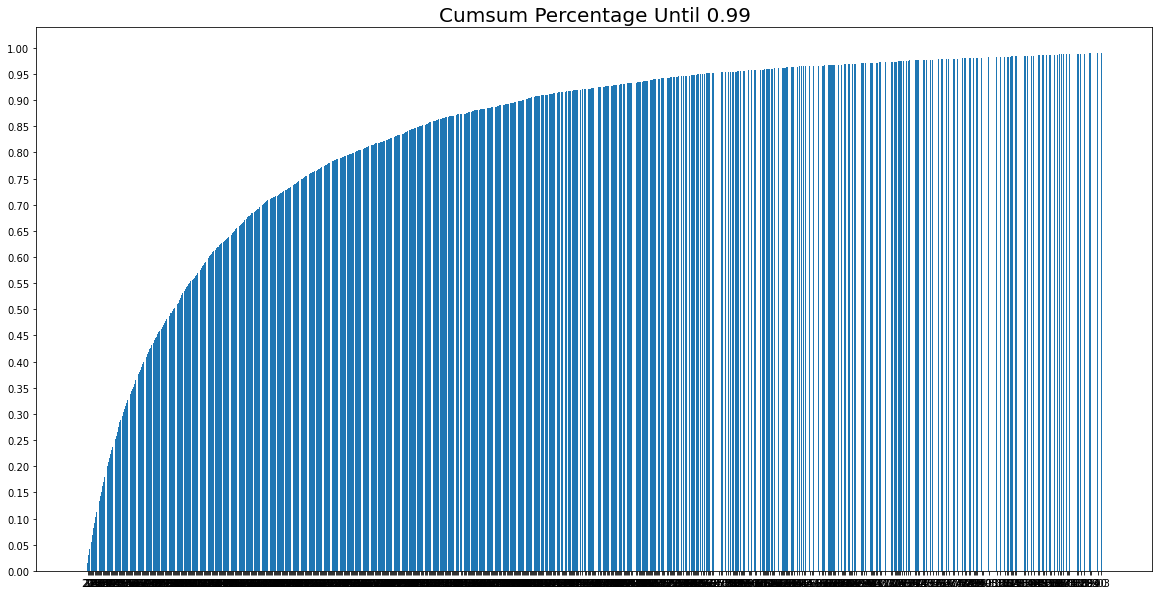

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_99.index,
        height=length_percent_cumsum_99)
plt.xticks(length_percent_cumsum_99.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.99', size=20)
plt.show()

**Matrix Factorization** model is widely used in Recommendation systems, which expresses the user-product relationship matrix as the product of a user matrix and a product matrix.   
However, it's not suitable here because there are too many blanks in the User * Item Matrix (data sparsity), so it is possible that the model is not trained properly. Since this session information cannot be organized based on user ID, if one session is viewed as one user, it becomes **much more sparse** than the existing user-product information matrix.

# 2. Data Preprocessing
We can start from basic analysis by item, session length, session time, cleaning, etc. are carried out.   
For this dataset, data is generated by UserID, not by Session, so we need to pay attention to how to interpret it by Session.   
- session length
- session time
- cleaning

I need to think about how I can separate UserID to a separate Session blocks.   
also, I need to convert the `Time` column type from `UTC time` to `datetime`.

In [15]:
data['Time'] = pd.to_datetime(data['Time'], unit='s')

## Session Time
We also need to consider the session time.   
For example, lets say A user wants to buy an iPhone. 
- There will be a lot of people looking to buy the iPhone SE2 in May 2020.
- However, in the next few months, iPhone 12 purchases will increase dramatically.
- The same thing happens for movies and TV shows. Users' consumption patterns change quickly.
- For this reason, it is important to learn recent consumption trends when building a recommendation system. Now let's look at the time the data occurred.
- Also it's important to consider time zone (AM, PM, Dawn), access time, access day, season, last access time, past time in the shopping cart, etc.

In [16]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50




Okay, so there is total of 3 years worth data. I will try test a model with 1 year worth data first, then use 3 years data later.   

1. Use the whole data
2. Use 1 year data
3. Use 2 years data

## Data Cleansing

In [17]:
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_user(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_user(data: pd.DataFrame, shortest):
    user_len = data.groupby('UserId').size()
    user_use = user_len[user_len >= shortest].index
    data = data[data['UserId'].isin(user_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [18]:
data = cleanse_recursive(data, shortest=2, least_click=5)
data.shape
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


# 3. Train / Valid / Test Data Split

In [19]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    user_last_time = data.groupby('UserId')['Time'].max().sort_values()
    user_in_train = data[data['Time'] < final_time - dt.timedelta(n_days)]
    user_in_test = data[data['Time'] >= final_time - dt.timedelta(n_days)]
    
    before_date = user_in_train
    after_date = user_in_test
    return before_date, after_date

In [20]:
tr, test = split_by_date(data, n_days=150)
tr, val = split_by_date(tr, n_days=150)

In [21]:
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [22]:
tr, test = split_by_date(data, n_days=100)
tr, val = split_by_date(tr, n_days=100)

In [23]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 989344
	 Sessions: 6039
	 Items: 3416
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-08-12 13:53:29

* valid Set Stats Info
	 Events: 5200
	 Sessions: 245
	 Items: 1940
	 First Time : 2002-08-13 00:40:06
	 Last Time : 2002-11-20 16:38:40

* test Set Stats Info
	 Events: 5067
	 Sessions: 254
	 Items: 1887
	 First Time : 2002-11-20 20:30:02
	 Last Time : 2003-02-28 17:49:50



In [24]:
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

Save model to .pkl file

In [25]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

# 4. Data Pipeline

Refer to the `SESSION-BASED RECOMMENDATIONS WITH RECURRENT NEURAL NETWORKS`, we can implement `Session-Parallel Mini-Batch`.

## 1. SessionDataset

In [26]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

The click_offsets variable contains the index at which each session started.   
The session_idx variable is an np.array indexing each session.

In [27]:
# The click_offsets variable contains the index at which each session started.
# The session_idx variable is an np.array indexing each session.
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
24,1,2340,3,2000-12-31 22:01:43,4
36,1,1836,5,2000-12-31 22:02:52,5
3,1,3408,4,2000-12-31 22:04:35,6
7,1,2804,5,2000-12-31 22:11:59,7
47,1,1207,4,2000-12-31 22:11:59,8
0,1,1193,5,2000-12-31 22:12:40,9


In [28]:
tr_dataset.click_offsets

array([     0,     53,    182, ..., 988880, 989003, 989344], dtype=int32)

In [29]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 6036, 6037, 6038])

## 2. SessionDataLoader

Let's create a class that takes a SessionDataset object and creates a **Session-Parallel mini-batch.**
The `__iter__` method yields model inputs, labels, and locations where the session ends.
The mask will be used later to initialize the **RNN Cell State**.

In [30]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=100):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [31]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
24,1,2340,3,2000-12-31 22:01:43,4
36,1,1836,5,2000-12-31 22:02:52,5
3,1,3408,4,2000-12-31 22:04:35,6
7,1,2804,5,2000-12-31 22:11:59,7
47,1,1207,4,2000-12-31 22:11:59,8
0,1,1193,5,2000-12-31 22:12:40,9


In [32]:
iter_ex = iter(tr_data_loader)

In [33]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 53 65 54]
Label Item Idx are :       [ 1 54 62 24]
Previous Masked Input Idx are []


# 5. Model Configuration
## 1. Evaluation Metric

In the Session-Based Recommendation Task, when the model presents `k` items, it is recommended that there are at most `n` items that the *user clicks/purchased*.
- For this reason, we use the `recall@k` index, which extends the concept of recall, and the `Mean Average Precision@k` index, which extends the concept of precision.
- It is also important how many times you hit the recommendation. If you do a Google search and the results you want are not found on page 1 and appear on page 2, then user response will be greatly reduced.
- Therefore, we also use indicators that are order-sensitive, such as MRR and NDCG.

For this project, we will use `MRR` and `Recall@k`. `MRR` is the reciprocal value of the order in which the correct item came out.
Therefore, if the correct answer item appears in the front of the recommendation result, the index will be higher, and if it comes later or not, the index will be lower.

Reference for `NDCG`, `MRR`, `MAP`:  MRR vs MAP vs NDCG: Rank-Aware Evaluation Metrics And When To Use Them https://medium.com/swlh/rank-aware-recsys-evaluation-metrics-5191bba16832

In [34]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [35]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [36]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.01, epochs=3, k=20)

In [37]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(128, 1, 3416)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    520200    
_________________________________________________________________
dropout (Dropout)            (128, 50)                 0         
_________________________________________________________________
dense (Dense)                (128, 3416)               174216    
Total params: 694,416
Trainable params: 694,416
Non-trainable params: 0
_________________________________________________________________


# 6. Model Train

In [38]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)
        pred = model.predict(input_ohe, batch_size=args.batch_size)
#         pred_arg = tf.nn.top_k(pred, k=124, sorted=True)[1]  # softmax 값이 큰 순서대로 sorting 합니다.
        pred_arg = tf.argsort(pred, direction='DESCENDING')
    
        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [39]:
train_model(model, args)

Train:   0%|          | 0/7682 [00:00<?, ?it/s, accuracy=0.0703, train_loss=5.74] 

	 - Recall@20 epoch 1: 0.091518
	 - MRR@20    epoch 1: 0.023835



Train:   0%|          | 0/7682 [00:00<?, ?it/s, accuracy=0.0781, train_loss=5.21] 

	 - Recall@20 epoch 2: 0.098214
	 - MRR@20    epoch 2: 0.024509



Evaluation:  18%|█▊        | 7/38 [00:05<00:23,  1.30it/s]

	 - Recall@20 epoch 3: 0.098214
	 - MRR@20    epoch 3: 0.023396



On epoch 3, the first model achieved accuracy = 0, which is weird, and
- Recall@20 epoch 3: 0.098214
- MRR@20    epoch 3: 0.026351

Let's try with different `args` set. (higher epoch)

In [40]:
args_2 = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.01, epochs=20, k=20)
model_2 = create_model(args)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(128, 1, 3416)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    520200    
_________________________________________________________________
dropout_1 (Dropout)          (128, 50)                 0         
_________________________________________________________________
dense_1 (Dense)              (128, 3416)               174216    
Total params: 694,416
Trainable params: 694,416
Non-trainable params: 0
_________________________________________________________________


In [41]:
train_model(model_2, args_2)

Train:   0%|          | 0/7682 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.68]

	 - Recall@20 epoch 1: 0.082589
	 - MRR@20    epoch 1: 0.019060



Train:   0%|          | 0/7682 [00:00<?, ?it/s, accuracy=0.0703, train_loss=5.51] 

	 - Recall@20 epoch 2: 0.095982
	 - MRR@20    epoch 2: 0.025300



Train:   0%|          | 0/7682 [00:00<?, ?it/s, accuracy=0.109, train_loss=5.35] 

	 - Recall@20 epoch 3: 0.089286
	 - MRR@20    epoch 3: 0.023870



Train:   0%|          | 0/7682 [00:00<?, ?it/s, accuracy=0.0703, train_loss=5.3]  

	 - Recall@20 epoch 4: 0.099330
	 - MRR@20    epoch 4: 0.025316



Train:   0%|          | 0/7682 [00:00<?, ?it/s, accuracy=0.0859, train_loss=5.25] 

	 - Recall@20 epoch 5: 0.102679
	 - MRR@20    epoch 5: 0.025606



Train:   0%|          | 0/7682 [00:00<?, ?it/s, accuracy=0.102, train_loss=5.22]  

	 - Recall@20 epoch 6: 0.099330
	 - MRR@20    epoch 6: 0.023042



Train:   0%|          | 0/7682 [00:00<?, ?it/s, accuracy=0.102, train_loss=5.52]  

	 - Recall@20 epoch 7: 0.095982
	 - MRR@20    epoch 7: 0.026894



Train:   0%|          | 0/7682 [00:00<?, ?it/s, accuracy=0.0703, train_loss=5.27] 

	 - Recall@20 epoch 8: 0.095982
	 - MRR@20    epoch 8: 0.027019



Train:   0%|          | 0/7682 [00:00<?, ?it/s, accuracy=0.0703, train_loss=5.44] 

	 - Recall@20 epoch 9: 0.087054
	 - MRR@20    epoch 9: 0.024833



Train:   0%|          | 0/7682 [00:00<?, ?it/s, accuracy=0.0703, train_loss=5.5]  

	 - Recall@20 epoch 10: 0.100446
	 - MRR@20    epoch 10: 0.026768



Train:   0%|          | 0/7682 [00:00<?, ?it/s, accuracy=0.109, train_loss=5.28]  

	 - Recall@20 epoch 11: 0.098214
	 - MRR@20    epoch 11: 0.028988



Train:   0%|          | 0/7682 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.63]

	 - Recall@20 epoch 12: 0.102679
	 - MRR@20    epoch 12: 0.028030



Train:   0%|          | 0/7682 [00:00<?, ?it/s, accuracy=0.0859, train_loss=5.42] 

	 - Recall@20 epoch 13: 0.091518
	 - MRR@20    epoch 13: 0.026423



Train:   0%|          | 0/7682 [00:00<?, ?it/s, accuracy=0.0469, train_loss=5.27] 

	 - Recall@20 epoch 14: 0.095982
	 - MRR@20    epoch 14: 0.025568



Train:   0%|          | 0/7682 [00:00<?, ?it/s, accuracy=0.0703, train_loss=5.39] 

	 - Recall@20 epoch 15: 0.095982
	 - MRR@20    epoch 15: 0.026680



Train:   0%|          | 0/7682 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.54] 

	 - Recall@20 epoch 16: 0.091518
	 - MRR@20    epoch 16: 0.023288



Train:   0%|          | 0/7682 [00:00<?, ?it/s, accuracy=0.0547, train_loss=5.43] 

	 - Recall@20 epoch 17: 0.094866
	 - MRR@20    epoch 17: 0.025845



Train:   0%|          | 0/7682 [00:00<?, ?it/s, accuracy=0.0703, train_loss=5.41] 

	 - Recall@20 epoch 18: 0.098214
	 - MRR@20    epoch 18: 0.023474



Train:   0%|          | 0/7682 [00:00<?, ?it/s, accuracy=0.0938, train_loss=5.31] 

	 - Recall@20 epoch 19: 0.092634
	 - MRR@20    epoch 19: 0.024643



Evaluation:  18%|█▊        | 7/38 [00:05<00:23,  1.31it/s]

	 - Recall@20 epoch 20: 0.088170
	 - MRR@20    epoch 20: 0.024014



Unfortunately, the model stopped because of losing connection from the Aiffel Node, but I think I already got a meaningful result.    
On epoch 17, it achieved accuracy=0.0469, train_loss=5.59, and
- Recall@20 epoch 17: 0.085938
- MRR@20    epoch 17: 0.021891

# 7. Model Test and check Recall and MRR

In [42]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

In [43]:
test_model(model, args, test)


Evaluation:  22%|██▏       | 8/37 [00:06<00:22,  1.29it/s]

	 - Recall@20: 0.118164
	 - MRR@20: 0.033001



In [44]:
test_model(model_2, args_2, test)


Evaluation:  22%|██▏       | 8/37 [00:06<00:21,  1.32it/s]

	 - Recall@20: 0.109375
	 - MRR@20: 0.036467



# 8. Conclusion
# Results
- There is not much difference between those two models.

# What I've learned
-  Preprocess the Movielens dataset from the perspective of session based recommendation was systematically carried out.
-  The RNN-based predictive model was normally configured and training proceeded stably.
-  Changed the session definition, model structure, hyperparameters, etc. and observed the changes in Recall and MRR.
# Challenges I've Faced
- It was difficult to create sessions from the user ratings data.
- So I chose to use userId as a sessionId to run the session-based recommendation model.

# What to do further
- I only used the whole data for the train/valid/test dataset.
- Further, I can try to split the data to use 1 year, and 2 years worth data as train/valid/test dataset.
- Also I can try to tune the hyperparameters for the model to improve the model functionality.

# References
Model:
- SESSION-BASED RECOMMENDATIONS WITH RECURRENT NEURAL NETWORKS (https://arxiv.org/pdf/1511.06939v4.pdf)
